# Time Series Analysis Box-Jenkins
## Part 3: Chapter 11: Transfer Function Models

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def show_markov(P,runs,runlen,initial):
    import matplotlib.pyplot as plt
    import numpy as np
    times = np.arange(1,runlen+1)
    out_data = np.zeros((runs,runlen))
    out_data[:,0] = initial
    for run in range(runs):
        for step in range(1,runlen):
            out_data[run,step] = np.random.choice(len(P), 1, p=P[int(out_data[run,step-1])])[0]
    [plt.plot(times,out_data[i,:]) for i in range(runs)]
    plt.xlabel("Time")
    plt.ylabel("State")
    plt.show()

In [2]:
def LinearTransfer(X,v):
    Y = np.zeros((len(X),1))
    for i in range(len(Y)):
        Xi = X[max(0,i-len(v)):i]
        vi = np.flip(v[:len(Xi)])
        Y[i] = np.dot(Xi.T,vi)
    return Y

[1.00000000e+00 4.06569660e-01 1.65298888e-01 6.72055127e-02
 2.73237224e-02 1.11089965e-02 4.51658094e-03 1.83630478e-03
 7.46585808e-04]
G:  1.6846062512154885


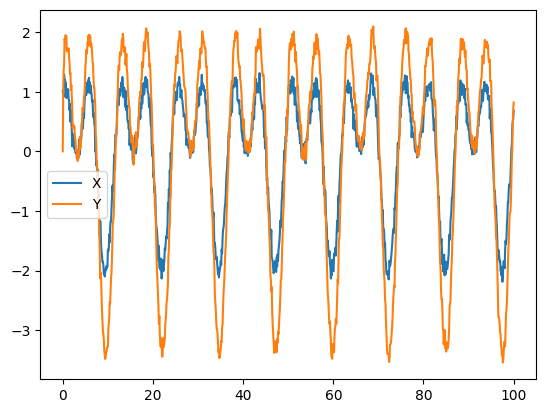

In [5]:
timesamples = 1000
lv = 8
v = np.exp(-.9*np.arange(0,lv+1))
# v[0] = .4
print(v)
print("G: ",str(np.sum(v)))
t = np.linspace(0,100,timesamples)
X = np.sin(.5*t)+np.cos(t) + .1*np.random.randn(1,timesamples)
# X = np.array([1]*timesamples) # shows Y_inf = g

X = X.reshape(-1,1)
plt.plot(t,X,label="X")
plt.plot(t,LinearTransfer(X,v),label="Y")
plt.legend()
plt.show()

### Laplace Transform Type Behavior

In [6]:
def get_v(de,om,b):
    v = np.zeros((7*(len(de)+len(om)+b),1))
    s = len(om)
    for j in range(len(v)):
        dv = sum([di*v[j-i-1] for i,di in enumerate(de)])
        if j == b:
            v[j] = om[0]
        elif j > b and j < b+s:
            v[j] = dv - om[j-b]
        else:
            v[j] = dv
    return v
def get_g(de,om):
    numerator = om[0] - sum(om[1:])
    denominator = 1 - sum(de)
    return numerator/denominator
def c_xy_k(X,Y,k):
    xbar = np.mean(X)
    ybar = np.mean(Y)
    n = len(X)
    if k >= 0:
        return 1/n*sum([(X[i]-xbar)*(Y[i+k]-ybar) for i in range(0,n-k)])
    else:
        return 1/n*sum([(Y[i]-ybar)*(X[i-k]-xbar) for i in range(0,n+k)])
def r_xy_k(X,Y,k):
    return c_xy_k(X,Y,k)/np.std(X)/np.std(Y)

Generation

G: 5.769230769230769


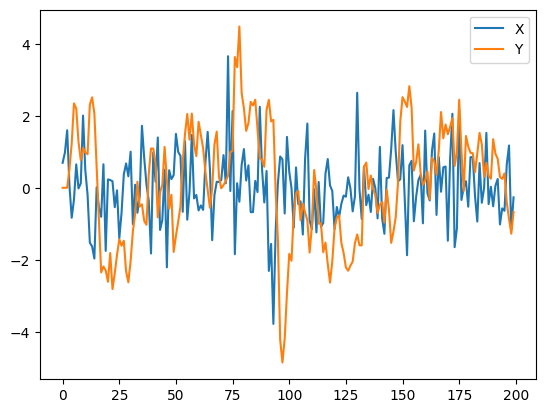

In [7]:
delta = [.97,-.1]
r = len(delta)
omega = [5*.15]#,-5*.4]
s = len(omega)
g = get_g(delta,omega)
print("G:",g)
v = get_v(delta,omega,2)
t = np.arange(0,200)
X = np.cos(t)
X = np.zeros((200,1))
X[4::20] = 1
X[5::20] = 1
X[6::20] = 1
X = np.random.randn(200)
Y = LinearTransfer(X,v)
plt.clf()
plt.plot(t,X,label="X")
plt.plot(t,Y,label="Y")
plt.legend()
plt.show()

Identifying Parameters

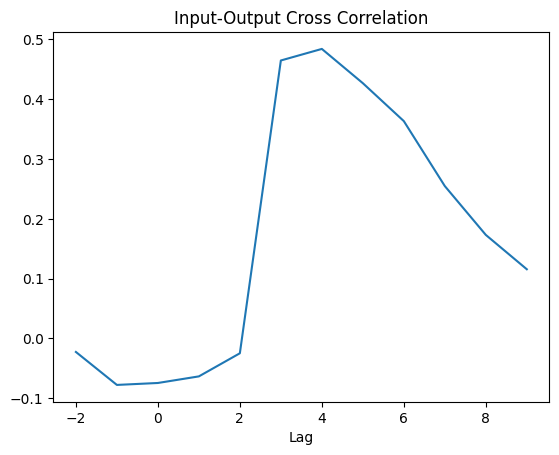

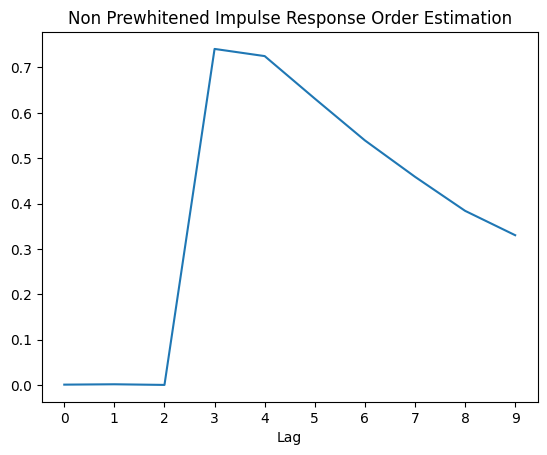

In [8]:
lk = -2
rk = 10
rxy = [r_xy_k(X,Y,k) for k in range(lk,rk)]
plt.plot(np.arange(lk,rk),rxy)
plt.title("Input-Output Cross Correlation")
plt.xlabel("Lag")
plt.show()

K = 20
gamma = np.zeros((K+1,K+1))
for i in range(K+1):
    for j in range(K+1):
        cxx = c_xy_k(X,X,abs(i-j))
        gamma[i,j] = cxx
c_xy = np.array([c_xy_k(X,Y,k) for k in range(0,K+1)])
solution = np.linalg.solve(gamma, c_xy)
plt.plot(solution[:10])
plt.xticks(np.arange(0,10))
plt.title("Non Prewhitened Impulse Response Order Estimation")
plt.xlabel("Lag")
plt.show()

## Re-learning 6/24
convention: last element in array is latest in time so a "backshift" operator B pushes values **forwards** in the array 

In [61]:
from scipy.sparse import diags, identity
from scipy.special import binom

In [99]:
def F(Ni,m): # back shift
  return diags(np.ones(Ni-m),m)
def B(Ni,m): # front shift
  return F(Ni,m).T
def Nabla(Ni,m): # mth backward finite difference
  out = identity(Ni)
  for i in range(1,m+1):
    out += (-1)**i*binom(m,i)*B(Ni,i)
  return out
def pulse(Ni,i):
  p = np.zeros(Ni)
  p[i] = 1
  return p
def lfilter(Ni,psi):
  out = psi[0]*identity(Ni)
  for i,psi_i in enumerate(psi[1:]):
    out += psi_i*B(Ni,i+1)
  return out

#### Testing Utility Functions

In [102]:
N=10
i_10 = pulse(N,4)
print(i_10)
print(B(N,1)@i_10)
print(B(N,2)@i_10)
print(F(N,1)@i_10)
print(F(N,2)@i_10)
print(Nabla(N,1)@i_10)
print(Nabla(N,2)@i_10)
print(Nabla(N,3)@i_10)
psi = [np.exp(-.9*i) for i in range(5)]
psi_filter = lfilter(N,psi)
print(psi_filter@i_10)

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[ 0.  0.  0.  0.  1. -1.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
[ 0.  0.  0.  0.  1. -3.  3. -1.  0.  0.]
[0.         0.         0.         0.         1.         0.40656966
 0.16529889 0.06720551 0.02732372 0.        ]


In [109]:
N = 100
t = np.arange(N)
a = np.random.randn(N)
cos = np.cos(.5*t)
i_10 = 10*pulse(N,10)
Psi_filter2 = lfilter(N,[np.exp(-.5*i) for i in range(20)])

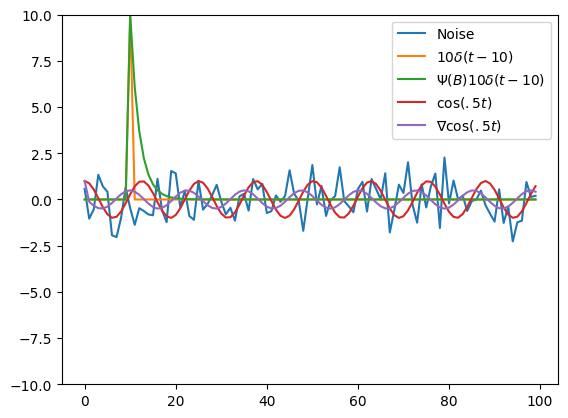

In [110]:
plt.plot(t,a,label="Noise")
plt.plot(t,i_10,label=r"$10\delta(t-10)$")
plt.plot(t,Psi_filter2@i_10,label=r"$\Psi(B)10\delta(t-10)$")
plt.plot(t,cos,label=r"$\cos(.5t)$")
plt.plot(t,Delta(N,1)@cos,label=r"$\nabla\cos(.5t)$")
plt.legend()
plt.ylim([-10,10])
plt.show()

### Autoregressive Models
$$\phi(B)z_t = a_t$$
where $a_t$ is white noise, phi truncates with p terms, offset by mu, variance of white noise = p+2 params

Sequence: [0.1 0.2 0.4 0.2 0.1]
Roots: [-0.743+1.529j -0.743-1.529j -0.257+0.529j -0.257-0.529j])


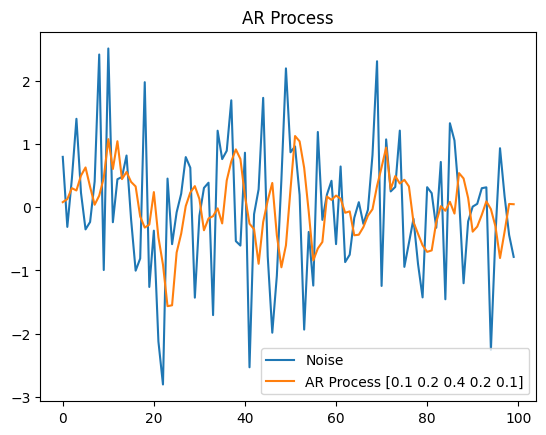

In [124]:
N = 100
t = np.arange(N)
sigma =1
a_t = sigma*np.random.randn(N)
phi = np.array([.1,.2,.4,.2,.1])
print(f"Sequence: {phi}")
phi_roots = np.roots(phi)
print(f"Roots: {np.round(phi_roots,3)})")
Psi_b = lfilter(N,phi)
plt.plot(t,a_t,label="Noise")
plt.plot(t,Psi_b@a_t,label=f"AR Process {phi}")
plt.legend()
plt.title("AR Process")
plt.show()


## Transfer Functions & Discrete Laplace Transforms

In [ ]:
## Tran